# 单因子示例2：

考虑流动性与交易限制，绘制分组收益曲线、多空对冲，计算单调性得分；
计算因子IC值

因子：价格、EP、BP

流动性与交易限制：

- 涨停无法买入: 从候选股票中过滤掉涨停股票。

- 跌停无法卖出: 持有到下个交易日继续卖出

- 停牌无法交易：买入时停牌，按"涨停无法买入"的说明处理；卖出时停牌，按"跌停无法卖出"的说明处理。

- 退市： 按退市前最后一个交易日的价格平仓

## 1. 导入常用包

In [3]:
import logging
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

from dateutil.parser import parse
from qdatasdk import *
from utility import *

## 2. 价格因子检验：考虑流动性与交易限制

-  停牌、涨停不买入
-  停牌、跌停不卖出
-  绘制回测曲线
-  计算IC

### 2.1 定义因子检验参数

In [4]:
params = {
    # 开始时间
    "start_date": "2013-01-01",
    # 截止时间
    "end_date": "2019-12-31",
    # 再平衡周期(20个交易日)
    "adjust_days": 20,
    # 分组数量
    "group_number": 5,
    # 因子
    "factor": "Price"
}


# 初始化日志
init_logging(params.get("factor"), level=logging.INFO)

### 2.2 加载数据： 包括日k、停复牌、涨跌停

#### 停牌数据处理

##### 原始停牌数据

In [5]:
# 停复牌数据
get_paused("000001.XSHE", params.get("start_date"), params.get("end_date"))

,begin_time,end_time
0,2013-09-06 09:30:00,2013-09-09 09:30:00
1,2014-07-15 09:30:00,2014-07-16 09:30:00


##### 数据对齐

In [9]:
def load_trade_dates(start_date, end_date):
    """
    加载交易日数据
    :return: 回测期间所有的交易日
    """
    dates = get_trade_days(start_date, end_date)
    dates = sorted(dates)
    return dates


def load_paused_data(security, start_date, end_date):
    """
    获取停复牌数据[全天停牌]
    :param security: 标的代码
    :param start_date: 开始日期
    :param end_date: 截至日期
    :return: Series类型。 标的是否停牌
    """
    df = get_paused(security, start_date, end_date)
    trade_dates = load_trade_dates(start_date, end_date)
    # 查询到停牌数据
    if type(df) == DataFrame and len(df) > 0:
        size = len(df)
        data = []
        idx = 0
        for td in trade_dates:
            paused = False
            while idx < size:
                p_time = df.iloc[idx]
                # 停牌日期
                pause_date = p_time['begin_time'].date()
                # 复牌日期
                resume_date = p_time['end_time'].date()
                if pause_date <= td < resume_date:
                    paused = True
                    break
                if td >= resume_date:
                    idx += 1
                    continue
                if td < pause_date:
                    break
            data.append({"date": td, "paused": paused})
    else:
        # 没有停牌数据
        data = [{"date": td, "paused": False} for td in trade_dates]

    df = pd.DataFrame(data)
    df.sort_values(['date'], inplace=True, ascending=True)
    df.set_index(['date'], inplace=True)
    return df["paused"]


#####  结果示例

In [10]:
load_paused_data("000001.XSHE", params.get("start_date"), params.get("end_date"))

date
2013-01-04    False
2013-01-07    False
2013-01-08    False
2013-01-09    False
2013-01-10    False
              ...  
2019-12-25    False
2019-12-26    False
2019-12-27    False
2019-12-30    False
2019-12-31    False
Name: paused, Length: 1702, dtype: bool

#### 涨跌停数据

In [11]:
get_limit_price("000001.XSHE", params.get("start_date"), params.get("end_date"))

,up,down
date,,
2013-01-04,17.620,14.420
2013-01-07,17.590,14.390
2013-01-08,17.930,14.670
2013-01-09,17.600,14.400
2013-01-10,17.450,14.270
...,...,...
2019-12-25,18.040,14.760
2019-12-26,17.930,14.670
2019-12-27,18.120,14.820


In [12]:
get_extras("is_st", "000001.XSHE", params.get("start_date"), params.get("end_date"))

,is_st
date,
2013-01-04,False
2013-01-07,False
2013-01-08,False
2013-01-09,False
2013-01-10,False
...,...
2019-12-25,False
2019-12-26,False
2019-12-27,False


#### 合并数据：日K、复权、停牌、涨跌停

In [13]:
def calc_fq(close, fq_factors):
    """
    获取复权[前复权]数据
    :param close: 收盘价序列
    :param fq_factors:  DataFrame类型: 复权因子序列
    :return: Series类型, 复权后的收盘价序列
    """
    if type(fq_factors) == DataFrame and len(fq_factors) > 0:
        # 复权价 = 累计前复权因子 * 不复权价
        factor = fq_factors["factor"]
        df = pd.concat([close, factor], sort=True, axis=1)
        # 只有除息日才有复权因子。除息日不需要复权, 所以把除息日的复权因子与除息日前一个交易日对齐。
        df['factor'] = df['factor'].shift(-1)
        # 使用除息日前一个交易日的复权因子, 填充该交易日之前的复权因子
        df = df.fillna(method="bfill")
        # 使用1填充,最近一个除息日、以及该除息日之后每个交易日的复权因子
        df = df.fillna(value=1)
        # 默认价格是np.float64类型，复权因子是float类型，计算前先做数据类型转换
        df["fq_close"] = df['close'] * (df["factor"].apply(np.float64))
        return df["fq_close"]
    else:
        return close.rename("fq_close")


def load_history_bar(security, start_date, end_date): #经过了复权，涨跌停等各种处理
    """
    加载指定标的、指定时间段内的历史K线数据
    获取复权[前复权]处理后的日K数据
    :param security: 标的代码
    :param start_date: 开始日期
    :param end_date: 截至日期
    :return: pd.DataFrame类型, 日K数据
    """
    bars = get_bars(security, start_date, end_date, unit="1d")
    if not (type(bars) == DataFrame and len(bars) > 0):
        return pd.DataFrame([])
    close = bars["close"]
    fq_factors = get_adj_factors(security, start_date, end_date, fq="pre")
    # 对收盘价做前复权
    fq_close = calc_fq(close, fq_factors)
    paused = load_paused_data(security, start_date, end_date)
    is_st = get_extras("is_st", security, start_date, end_date)
    limit = get_limit_price(security, start_date, end_date)
    dfs = [bars, fq_close, paused, is_st]
    if type(limit) == DataFrame and len(limit) > 0:
        dfs.append(limit)
    else:
        logging.warning(f"没有查询到涨跌停数据：标的{security}, 长期停牌或已经退市")
    df = pd.concat(dfs, sort=True, axis=1)
    df.dropna(inplace=True)
    return df

#####  结果示例

In [9]:
load_history_bar("000587.XSHE", params.get("start_date"), params.get("end_date"))

,open,high,low,close,volume,money,fq_close,paused,is_st,up,down
date,,,,,,,,,,,
2013-01-04,13.78,14.14,13.63,13.85,7477278.0,1.039522e+08,6.817728,False,True,15.090,12.350
2013-01-07,0.00,0.00,0.00,13.85,0.0,0.000000e+00,6.817728,True,True,15.240,12.470
2013-01-08,0.00,0.00,0.00,13.85,0.0,0.000000e+00,6.817728,True,True,15.240,12.470
2013-01-09,0.00,0.00,0.00,13.85,0.0,0.000000e+00,6.817728,True,True,15.240,12.470
2013-01-10,0.00,0.00,0.00,13.85,0.0,0.000000e+00,6.817728,True,True,15.240,12.470
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,1.80,1.83,1.79,1.80,23655640.0,4.272695e+07,1.800000,False,True,1.970,1.610
2019-12-26,1.80,1.83,1.77,1.80,24799684.0,4.457964e+07,1.800000,False,True,1.980,1.620
2019-12-27,1.80,1.85,1.80,1.83,47272902.0,8.656714e+07,1.830000,False,True,1.980,1.620


#### 加载沪、深两市历史数据

In [14]:
def load_history(start_date, end_date):
    """
    加载历史数据
    :param start_date:
    :param end_date:
    :return:
    """
    # 获取全市场标的: 沪、深两市
    df = get_all_securities()
    counter = 0
    total = len(df)
    data = {}
    dates = load_trade_dates(start_date, end_date)
    start_date = dates[0]
    end_date = dates[-1]
    for idx, row in df.iterrows():
        counter += 1
        # 回测截至日期之后还没有上市
        if row["start_date"] >= end_date:
            continue
        # 回测开始日期之前已经退市
        if row["end_date"] and row["end_date"] < start_date:
            continue
        data[idx] = load_history_bar(idx, start_date, end_date)
        if counter % 100 == 0 or counter == total:
            logging.warning(f"loading history data: {round(counter * 100 / total, 2)}%")
    return data

In [15]:
# 运行加载数据
HistoryData = load_history(params.get("start_date"), params.get("end_date"))

2023-03-27 15:32:25,721 WARNING loading history data: 1.96%
2023-03-27 15:33:42,501 WARNING loading history data: 3.92%
2023-03-27 15:35:06,765 WARNING loading history data: 5.88%
2023-03-27 15:36:29,189 WARNING loading history data: 7.84%
2023-03-27 15:37:55,717 WARNING loading history data: 9.81%
2023-03-27 15:39:20,389 WARNING loading history data: 11.77%
2023-03-27 15:40:48,309 WARNING loading history data: 13.73%
2023-03-27 15:42:12,215 WARNING loading history data: 15.69%
2023-03-27 15:43:40,853 WARNING loading history data: 17.65%
2023-03-27 15:45:08,164 WARNING loading history data: 19.61%
2023-03-27 15:46:35,827 WARNING loading history data: 21.57%
2023-03-27 15:48:01,823 WARNING loading history data: 23.53%
2023-03-27 15:49:30,659 WARNING loading history data: 25.5%
2023-03-27 15:50:57,104 WARNING loading history data: 27.46%
2023-03-27 15:52:26,991 WARNING loading history data: 29.42%
2023-03-27 15:53:53,036 WARNING loading history data: 31.38%
2023-03-27 15:55:16,424 WARNIN

#####  结果示例

In [12]:
# 检查数据
securities = list(HistoryData.keys())
print(len(securities))
security = securities[1]
bars = HistoryData[security]
bars

3797


,open,high,low,close,volume,money,fq_close,paused,is_st,up,down
date,,,,,,,,,,,
2013-01-04,0.00,0.00,0.00,10.12,0.0,0.000000e+00,6.736855,True,False,11.130,9.110
2013-01-07,0.00,0.00,0.00,10.12,0.0,0.000000e+00,6.736855,True,False,11.130,9.110
2013-01-08,0.00,0.00,0.00,10.12,0.0,0.000000e+00,6.736855,True,False,11.130,9.110
2013-01-09,0.00,0.00,0.00,10.12,0.0,0.000000e+00,6.736855,True,False,11.130,9.110
2013-01-10,0.00,0.00,0.00,10.12,0.0,0.000000e+00,6.736855,True,False,11.130,9.110
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,30.40,30.63,30.18,30.29,68503732.0,2.082008e+09,30.290000,False,False,33.420,27.340
2019-12-26,30.50,31.30,30.50,31.12,88879074.0,2.758745e+09,31.120000,False,False,33.320,27.260
2019-12-27,31.23,31.32,30.81,31.00,70309648.0,2.185107e+09,31.000000,False,False,34.230,28.010


In [13]:
for security, bars in HistoryData.items():
    factors = bars["close"]
    factors = factors.rename("Price")
    df = pd.concat([bars, factors], sort=True, axis=1)
    df.dropna(inplace=True)
    HistoryData[security] = df

### 2.3 因子检验

In [14]:
# 设置日志
init_logging(params.get("factor"), level=logging.INFO)

# 创建、初始化回测引擎
bt = Backtest(params, HistoryData)

# 启动
bt.run()

2023-03-17 15:03:52,658 WARNING 计算IC: date=2013-01-04, ic=None
2023-03-17 15:03:56,046 WARNING 计算IC: date=2013-02-01, ic=-0.04869899657761538
2023-03-17 15:03:59,431 WARNING 计算IC: date=2013-03-08, ic=0.07015675603108854
2023-03-17 15:04:02,756 WARNING 计算IC: date=2013-04-09, ic=0.04719453766731096
2023-03-17 15:04:06,077 WARNING 计算IC: date=2013-05-10, ic=0.1951322504226514
2023-03-17 15:04:09,523 WARNING 计算IC: date=2013-06-07, ic=-0.0019242198623153311
2023-03-17 15:04:12,848 WARNING 计算IC: date=2013-07-10, ic=0.2495296573800859
2023-03-17 15:04:16,291 WARNING 计算IC: date=2013-08-07, ic=-0.0034247733094452133
2023-03-17 15:04:19,670 WARNING 计算IC: date=2013-09-04, ic=-0.15716949303369404
2023-03-17 15:04:23,152 WARNING 计算IC: date=2013-10-11, ic=-0.029621711825761288
2023-03-17 15:04:26,596 WARNING 计算IC: date=2013-11-08, ic=-0.12016033130012188
2023-03-17 15:04:30,011 WARNING 计算IC: date=2013-12-06, ic=-0.05146407793865109
2023-03-17 15:04:33,465 WARNING 计算IC: date=2014-01-06, ic=0.290155502

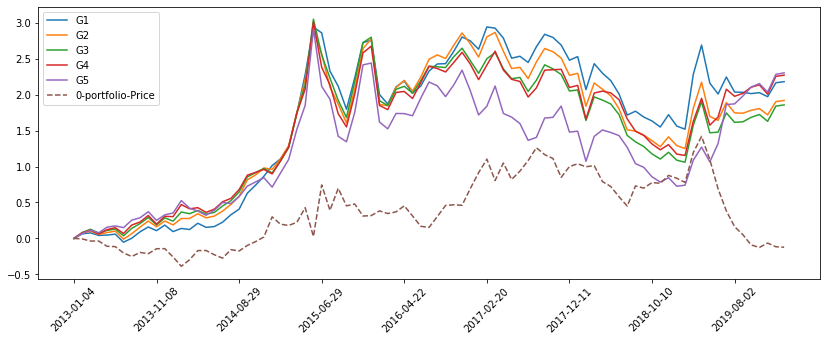

In [15]:
# 检验完成：输出结果

## 绘制收益曲线
bt.draw_profit()

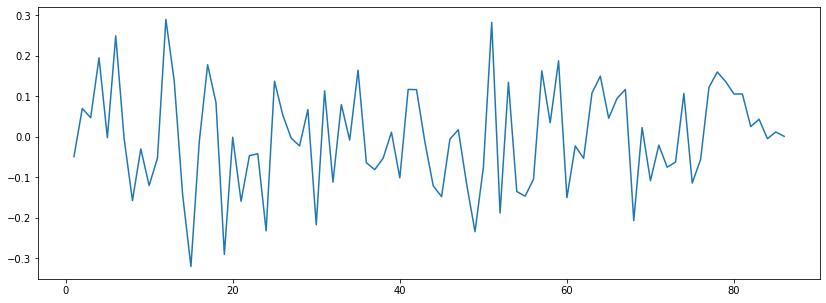

2023-03-17 15:10:24,039 WARNING 单调性得分 = 0.34813790256421284


0.34813790256421284

In [16]:
## 输出IC
plt.figure(figsize=(14, 5))
df = DataFrame(bt.ic_list)
plt.plot([i for i in range(0,len(df))], df["ic"]) #0-portfolio-price 是多空对冲，第一组收益减最后一组
plt.show()

## 计算单调性得分
bt.calc_m_score()

## 3. EP因子检验

### 3.1 定义因子检验参数

In [17]:
params = {
    # 开始时间
    "start_date": "2013-01-01",
    # 截止时间
    "end_date": "2019-12-31",
    # 再平衡周期(20个交易日)
    "adjust_days": 20,
    # 分组数量
    "group_number": 5,
    # 因子
    "factor": "EP"
}
# 初始化日志
init_logging(params.get("factor"), level=logging.INFO)

### 3.2 加载数据

#### 计算EP

In [18]:
# 查询财报数据
from sqlalchemy import and_
from sqlalchemy.orm import Query

def load_eps_data(security, start_date, end_date):
    """
    返回eps序列
    :param security:
    :param start_date:
    :param end_date:
    :return:
    """
    symbol = security.split(".")[0]
    fields = [FdmtIndiPsTtmPit.EPS, FdmtIndiPsTtmPit.PUBLISH_DATE,
              FdmtIndiPsTtmPit.END_DATE
              ]
    q = Query(fields).filter(and_(FdmtIndiPsTtmPit.PARTY_ID == Security.PARTY_ID,
                                  Security.TICKER_SYMBOL == symbol,
                                  FdmtIndiPsTtmPit.PUBLISH_DATE <= end_date)).order_by(
        FdmtIndiPsTtmPit.PUBLISH_DATE.asc(), FdmtIndiPsTtmPit.END_DATE.asc())
    df = get_fundamentals(q)
    if len(df)>0:
        # 同一期财报中，会披露当期数据、以及上一年度同期数据。这里过滤掉更新的上一年度同期数据
        df = df.drop_duplicates(subset='PUBLISH_DATE', keep="last")
        df.set_index(['PUBLISH_DATE'], inplace=True)
    return df

# 计算EP
def calc_ep(close: Series, eps: DataFrame, start_date: datetime, end_date: datetime):
    """
    根据财报中的每股净收益、每日行情的收盘价计算EP
    :param end_date:
    :param start_date:
    :param close: 收盘价序列
    :param eps: 财报中的每股净收益序列
    :return: EP序列
    """
    if type(eps) == DataFrame and len(eps) > 0:
        # 以日期为基准，对齐行情数据、财务数据
        df = pd.concat([close, eps], sort=True, axis=1)
        # 当日发布的财报数据，下一个交易日才能使用： EPS向下移动1个交易日，对齐到下个交易日
        df['EPS'] = df['EPS'].shift(1)
        # EPS为空的记录，使用最早的EPS： 使用前一条非nan的单元格填充当前为空的单元格
        df = df.fillna(method="ffill")
        # 计算EP
        # EP = EPS/收盘价
        ep = (df["EPS"].apply(np.float64)) / df["close"]
        # 过滤掉不在回测期间的数据
        ep = ep[(ep.index >= start_date) & (ep.index <= end_date)]
        return ep
    else:
        return Series([])


#####  结果示例

In [19]:
# 计算结果
security = "000005.XSHE"
start_date = params.get("start_date")
end_date = params.get("end_date")

eps = load_eps_data(security, params.get("start_date"), params.get("end_date"))
bars = get_bars(security, params.get("start_date"), params.get("end_date"), unit="1d")
trade_dates = load_trade_dates(params.get("start_date"), params.get("end_date"))
ep= calc_ep(bars["close"], eps, trade_dates[0], trade_dates[-1])
ep = ep.rename("EP")
ep

2013-01-04   -0.005797
2013-01-07   -0.005797
2013-01-08   -0.005777
2013-01-09   -0.005777
2013-01-10   -0.005758
                ...   
2019-12-25    0.058251
2019-12-26    0.056935
2019-12-27    0.057120
2019-12-30    0.057305
2019-12-31    0.057120
Name: EP, Length: 1708, dtype: float64

In [20]:
# 按日期索引，对齐数据：行情、复权价、停牌、涨跌停
bars = get_bars(security, start_date, end_date, unit="1d")
close = bars["close"]
fq_factors = get_adj_factors(security, start_date, end_date, fq="pre")
# 对收盘价做前复权
fq_close = calc_fq(close, fq_factors)
paused = load_paused_data(security, start_date, end_date)
limit = get_limit_price(security, start_date, end_date)
df = pd.concat([bars, fq_close, paused, limit, ep], sort=True, axis=1)
df.dropna(inplace=True)
df

,open,high,low,close,volume,money,fq_close,paused,up,down,EP
2013-01-04,2.99,3.03,2.92,2.95,8024374.0,23766916.00,2.95,False,3.270,2.670,-0.005797
2013-01-07,2.96,2.97,2.91,2.95,4804109.0,14094973.00,2.95,False,3.250,2.660,-0.005797
2013-01-08,2.94,2.99,2.91,2.96,8060371.0,23815822.00,2.96,False,3.250,2.660,-0.005777
2013-01-09,2.97,2.99,2.93,2.96,7408534.0,21932458.00,2.96,False,3.260,2.660,-0.005777
2013-01-10,2.95,2.99,2.94,2.97,6843534.0,20296170.00,2.97,False,3.260,2.660,-0.005758
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,3.05,3.05,3.01,3.03,4774100.0,14455554.00,3.03,False,3.360,2.750,0.058251
2019-12-26,3.03,3.14,3.03,3.10,12347927.0,38186876.01,3.10,False,3.330,2.730,0.056935
2019-12-27,3.10,3.14,3.08,3.09,9197001.0,28526697.09,3.09,False,3.410,2.790,0.057120
2019-12-30,3.06,3.09,3.01,3.08,6681155.0,20433243.80,3.08,False,3.400,2.780,0.057305


#### 加载EP历史数据


In [21]:
# 处理1支股票： 按日期索引，对齐数据：行情、复权价、停牌、涨跌停、IS_ST、EP
bars = HistoryData[security]
start_date, end_date = trade_dates[0], trade_dates[-1]
eps = load_eps_data(security, start_date, end_date)
ep = calc_ep(bars["close"], eps, start_date, end_date)
factors = ep.rename("EP")
df = pd.concat([bars, factors], sort=True, axis=1)
df.dropna(inplace=True)
df

,open,high,low,close,volume,money,fq_close,paused,is_st,up,down,Price,EP
2013-01-04,2.99,3.03,2.92,2.95,8024374.0,23766916.00,2.95,False,False,3.270,2.670,2.95,-0.005797
2013-01-07,2.96,2.97,2.91,2.95,4804109.0,14094973.00,2.95,False,False,3.250,2.660,2.95,-0.005797
2013-01-08,2.94,2.99,2.91,2.96,8060371.0,23815822.00,2.96,False,False,3.250,2.660,2.96,-0.005777
2013-01-09,2.97,2.99,2.93,2.96,7408534.0,21932458.00,2.96,False,False,3.260,2.660,2.96,-0.005777
2013-01-10,2.95,2.99,2.94,2.97,6843534.0,20296170.00,2.97,False,False,3.260,2.660,2.97,-0.005758
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,3.05,3.05,3.01,3.03,4774100.0,14455554.00,3.03,False,False,3.360,2.750,3.03,0.058251
2019-12-26,3.03,3.14,3.03,3.10,12347927.0,38186876.01,3.10,False,False,3.330,2.730,3.10,0.056935
2019-12-27,3.10,3.14,3.08,3.09,9197001.0,28526697.09,3.09,False,False,3.410,2.790,3.09,0.057120
2019-12-30,3.06,3.09,3.01,3.08,6681155.0,20433243.80,3.08,False,False,3.400,2.780,3.08,0.057305


In [22]:
# 加载所有股票： 追加EP数据
HistoryData_EP = {}
trade_dates = load_trade_dates(start_date, end_date)
start_date = trade_dates[0]
end_date = trade_dates[-1]
for security, bars in HistoryData.items():
    eps = load_eps_data(security, start_date, end_date)
    ep = calc_ep(bars["close"], eps, start_date, end_date)
    factors = ep.rename("EP")
    df = pd.concat([bars, factors], sort=True, axis=1)
    df.dropna(inplace=True)
    HistoryData_EP[security] = df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [23]:
# 检查数据
securities = list(HistoryData_EP.keys())
print(len(securities))
security = securities[-2]
print(security)
bars = HistoryData_EP[security]
bars

3797
603488.XSHG


,open,high,low,close,volume,money,fq_close,paused,is_st,up,down,Price,EP
2017-08-23,15.32,15.47,14.90,15.25,3510969.0,53293813.0,9.640233,False,False,16.870,13.810,15.25,0.022295
2017-08-24,15.15,15.58,15.13,15.24,4487732.0,68914325.0,9.633911,False,False,16.780,13.730,15.24,0.022310
2017-08-25,15.10,16.13,15.05,15.85,8445571.0,133182440.0,10.019520,False,False,16.760,13.720,15.85,0.021451
2017-08-28,15.95,16.37,15.84,16.25,7990902.0,128512959.0,10.272379,False,False,17.440,14.270,16.25,0.020923
2017-08-29,16.15,17.12,15.90,16.56,10134743.0,166783072.0,10.468344,False,False,17.880,14.630,16.56,0.020531
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,8.48,8.58,8.47,8.50,1238372.0,10549623.0,8.500000,False,False,9.360,7.660,8.50,0.045941
2019-12-26,8.49,8.76,8.49,8.71,3050149.0,26388125.0,8.710000,False,False,9.350,7.650,8.71,0.044834
2019-12-27,8.71,8.71,8.55,8.56,2515649.0,21667154.0,8.560000,False,False,9.580,7.840,8.56,0.045619
2019-12-30,8.53,9.40,8.41,8.92,6691164.0,59658433.0,8.920000,False,False,9.420,7.700,8.92,0.043778


### 3.3 因子检验

In [24]:
# 初始化日志
init_logging(params.get("factor"), level=logging.WARNING)
# 开始回测
ep_bt = Backtest(params, HistoryData_EP)
ep_bt.run()
#IC是人为根据因子给出的股票排名和最后收益的相关度，检验因子/人为预测的有效性，每个调仓周期（20days）预测一次

2023-03-17 15:11:03,474 WARNING 计算IC: date=2013-01-04, ic=None
2023-03-17 15:11:06,474 WARNING 计算IC: date=2013-02-01, ic=0.01032981682436543
2023-03-17 15:11:09,586 WARNING 计算IC: date=2013-03-08, ic=0.0301492325105767
2023-03-17 15:11:12,642 WARNING 计算IC: date=2013-04-09, ic=-0.0028773809534684415
2023-03-17 15:11:15,924 WARNING 计算IC: date=2013-05-10, ic=0.06413452949544672
2023-03-17 15:11:18,966 WARNING 计算IC: date=2013-06-07, ic=0.011307978331921193
2023-03-17 15:11:22,114 WARNING 计算IC: date=2013-07-10, ic=0.04227652238307993
2023-03-17 15:11:25,203 WARNING 计算IC: date=2013-08-07, ic=0.029580291419830176
2023-03-17 15:11:28,313 WARNING 计算IC: date=2013-09-04, ic=-0.029168492011199976
2023-03-17 15:11:31,420 WARNING 计算IC: date=2013-10-11, ic=0.013303706554572817
2023-03-17 15:11:34,820 WARNING 计算IC: date=2013-11-08, ic=-0.0301936481715532
2023-03-17 15:11:37,981 WARNING 计算IC: date=2013-12-06, ic=0.01301143492413127
2023-03-17 15:11:41,152 WARNING 计算IC: date=2014-01-06, ic=0.068477845253

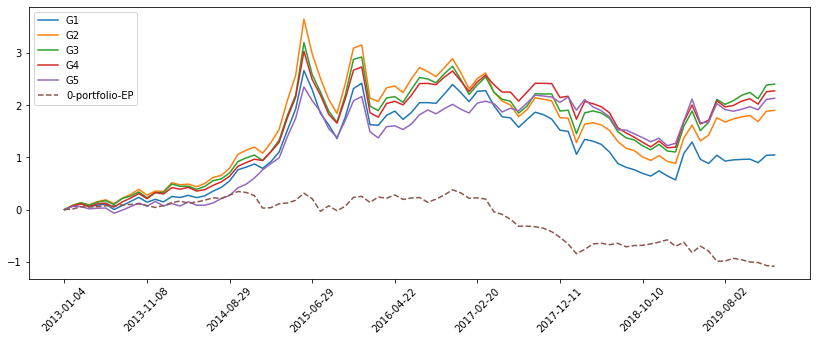

In [25]:
# 绘制收益曲线
ep_bt.draw_profit()

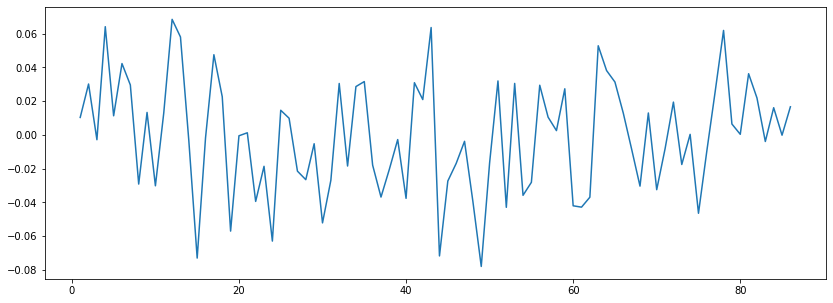

2023-03-17 15:17:08,841 WARNING 单调性得分 = 2.9052603072692564


2.9052603072692564

In [26]:
# IC
plt.figure(figsize=(14, 5))
df = DataFrame(ep_bt.ic_list)
plt.plot([i for i in range(0,len(df))], df["ic"])
plt.show()


# 单调性得分
ep_bt.calc_m_score()

## 4.BP因子检验

### 4.1 定义因子检验参数

In [27]:
params = {
    # 开始时间
    "start_date": "2013-01-01",
    # 截止时间
    "end_date": "2019-12-31",
    # 再平衡周期(20个交易日)
    "adjust_days": 20,
    # 分组数量
    "group_number": 5,
    # 因子
    "factor": "BP"
}
# 初始化日志
init_logging(params.get("factor"), level=logging.INFO)

### 4.2 加载数据

#### 计算BP

In [28]:
def load_bps_data(security, start_date, end_date):
    """
    返回bps序列
    :param security:
    :param start_date:
    :param end_date:
    :return:
    """
    symbol = security.split(".")[0]
    fields = [FdmtIndiPsPit.N_ASSET_PS, FdmtIndiPsPit.ACT_PUBTIME,
              FdmtIndiPsPit.END_DATE
              ]
    q = Query(fields).filter(and_(FdmtIndiPsPit.PARTY_ID == Security.PARTY_ID,
                                  Security.TICKER_SYMBOL == symbol,
                                  FdmtIndiPsPit.ACT_PUBTIME <= end_date)).order_by(
        FdmtIndiPsPit.ACT_PUBTIME.asc(), FdmtIndiPsPit.END_DATE.asc())
    df = get_fundamentals(q)
    if len(df)>0:    
        # 同一次发布的期财报中，会披露当期数据、以及上一年度同期数据。这里过滤掉更新的上一年度同期数据
        df['ACT_PUBTIME'] = df["ACT_PUBTIME"].apply(lambda x: x.date())
        df = df.drop_duplicates(subset='ACT_PUBTIME', keep="last")
        # 实际披露时间是datetime类型，转换成date类型
        df.set_index(['ACT_PUBTIME'], inplace=True)
        df.rename(columns={"N_ASSET_PS": "BPS"}, inplace=True)
    return df


    
def calc_bp(close: Series, bps: DataFrame, start_date: datetime, end_date: datetime):
    """
    根据财报中的每股净资产、每日行情的收盘价计算BP
    :param end_date:
    :param start_date:
    :param close: 收盘价序列
    :param bps: 财报中的每股净资产序列
    :return: BP序列
    """
    if type(bps) == DataFrame and len(bps) > 0:
        # 以日期为基准，对齐行情数据、财务数据
        df = pd.concat([close, bps], sort=True, axis=1)
        # 当日发布的财报数据，下一个交易日才能使用： BPS向下移动1个交易日，对齐到下个交易日
        df['BPS'] = df['BPS'].shift(1)
        # BPS为空的记录，使用最早的BPS： 使用前一条非nan的单元格填充当前为空的单元格
        df = df.fillna(method="ffill")
        # 计算BP
        # BP = BPS/收盘价
        bp = (df["BPS"].apply(np.float64)) / df["close"]
        # 过滤掉不在回测期间的数据
        bp = bp[(bp.index >= start_date) & (bp.index <= end_date)]        
        return bp
    else:
        return Series([])


#### 加载BP数据

In [29]:
# 加载历史数据：追加BP数据

HistoryData_BP = {}
trade_dates = load_trade_dates(start_date, end_date)
start_date = trade_dates[0]
end_date = trade_dates[-1]
for security, bars in HistoryData.items():
    bps = load_bps_data(security, start_date, end_date)
    bp = calc_bp(bars["close"], bps, start_date, end_date)
    factors = bp.rename("BP")
    df = pd.concat([bars, factors], sort=True, axis=1)
    df.dropna(inplace=True)
    HistoryData_BP[security] = df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [30]:
# 检查数据
securities = list(HistoryData_BP.keys())
print(len(securities))
security = securities[-1]
print(security)
bars = HistoryData_BP[security]
bars

3797
603679.XSHG


,open,high,low,close,volume,money,fq_close,paused,is_st,up,down,Price,BP
2017-06-21,13.59,13.59,13.59,13.59,12100.0,164439.0,9.580824,False,False,13.590,6.040,13.59,0.259750
2017-06-22,14.95,14.95,14.95,14.95,3637.0,54373.0,10.539611,False,False,14.950,12.230,14.95,0.236120
2017-06-23,16.45,16.45,16.45,16.45,4028.0,66261.0,11.597097,False,False,16.450,13.460,16.45,0.214590
2017-06-26,18.10,18.10,18.10,18.10,4700.0,85070.0,12.760332,False,False,18.100,14.810,18.10,0.195028
2017-06-27,19.91,19.91,19.91,19.91,28939.0,576175.0,14.036365,False,False,19.910,16.290,19.91,0.177298
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,42.27,42.64,41.39,41.94,1011000.0,42472645.0,41.940000,False,False,46.380,37.940,41.94,0.155377
2019-12-26,42.30,42.58,41.46,41.97,656000.0,27532401.0,41.970000,False,False,46.130,37.750,41.97,0.155266
2019-12-27,42.38,42.60,40.70,40.89,1157941.0,48182256.0,40.890000,False,False,46.170,37.770,40.89,0.159367
2019-12-30,40.92,41.10,40.10,40.70,930780.0,37767971.0,40.700000,False,False,44.980,36.800,40.70,0.160111


### 4.3 因子检验

In [31]:
bp_bt = Backtest(params, HistoryData_BP)
bp_bt.run()

2023-03-17 15:17:50,657 WARNING 计算IC: date=2013-01-04, ic=None
2023-03-17 15:17:53,611 WARNING 计算IC: date=2013-02-01, ic=0.04727950551149159
2023-03-17 15:17:56,642 WARNING 计算IC: date=2013-03-08, ic=0.04691137197344161
2023-03-17 15:17:59,645 WARNING 计算IC: date=2013-04-09, ic=0.06438094300295788
2023-03-17 15:18:02,574 WARNING 计算IC: date=2013-05-10, ic=0.04067875145017132
2023-03-17 15:18:05,838 WARNING 计算IC: date=2013-06-07, ic=0.05659692764383008
2023-03-17 15:18:08,830 WARNING 计算IC: date=2013-07-10, ic=0.06315466085903601
2023-03-17 15:18:11,986 WARNING 计算IC: date=2013-08-07, ic=0.009345671036353163
2023-03-17 15:18:15,118 WARNING 计算IC: date=2013-09-04, ic=-0.05357711689328741
2023-03-17 15:18:18,230 WARNING 计算IC: date=2013-10-11, ic=-0.01798971067409394
2023-03-17 15:18:21,283 WARNING 计算IC: date=2013-11-08, ic=-0.09810440833094809
2023-03-17 15:18:24,326 WARNING 计算IC: date=2013-12-06, ic=-0.10089323561116952
2023-03-17 15:18:27,397 WARNING 计算IC: date=2014-01-06, ic=0.10407838080660

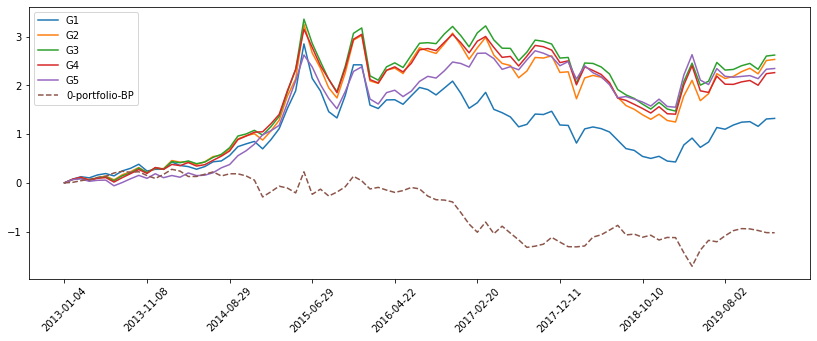

In [32]:
# 绘制收益曲线
bp_bt.draw_profit()

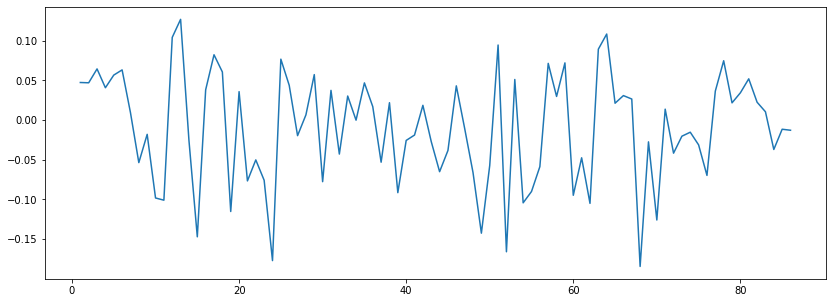

2023-03-17 15:23:49,255 WARNING 单调性得分 = -3.783701820486057


-3.783701820486057

In [33]:
# IC
plt.figure(figsize=(14, 5))
df = DataFrame(bp_bt.ic_list)
plt.plot([i for i in range(0,len(df))], df["ic"])
plt.show()


# 单调性得分
bp_bt.calc_m_score()